# Import Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Matplolib default parameters
from matplotlib import rcParams
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

# import warning
import warnings
warnings.filterwarnings('ignore')

# Dataset Overview

For this project, we perform binary classification on the Census Income dataset available from the <a href = 'http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a><br>
The goal is to determine if an individual earns more than $50K based on a set of continuous and categorical variables.

In [2]:
df = pd.read_csv('income.csv')
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [3]:
print(f'this dataset contains of {df.shape[0]} rows and {df.shape[1]} columns')

this dataset contains of 30000 rows and 10 columns


In [4]:
# check null values
df.isnull().sum()

age               0
sex               0
education         0
education-num     0
marital-status    0
workclass         0
occupation        0
hours-per-week    0
income            0
label             0
dtype: int64

In [5]:
# check duplicated values
df.duplicated().sum()

7675

In [6]:
# drop duplicate
df = df.drop_duplicates()
df.shape

(22325, 10)

# Exploratory Data Analysis

In [7]:
# copy data
eda = df.copy()

# define cat and num features
cat = eda.select_dtypes(include='object').columns
num = eda.select_dtypes(include='number').columns

## Descriptive Statistic

In [8]:
eda[num].describe().T

,count,mean,std,min,25%,50%,75%,max
age,22325.0,38.980067,12.964153,18.0,28.0,38.0,48.0,90.0
education-num,22325.0,10.267413,2.629835,3.0,9.0,10.0,13.0,16.0
hours-per-week,22325.0,41.928824,10.360761,20.0,40.0,40.0,48.0,90.0
label,22325.0,0.287212,0.452471,0.0,0.0,0.0,1.0,1.0


## Univariate Feature Analysis

In [9]:
len(num)

4

### Numeric Features

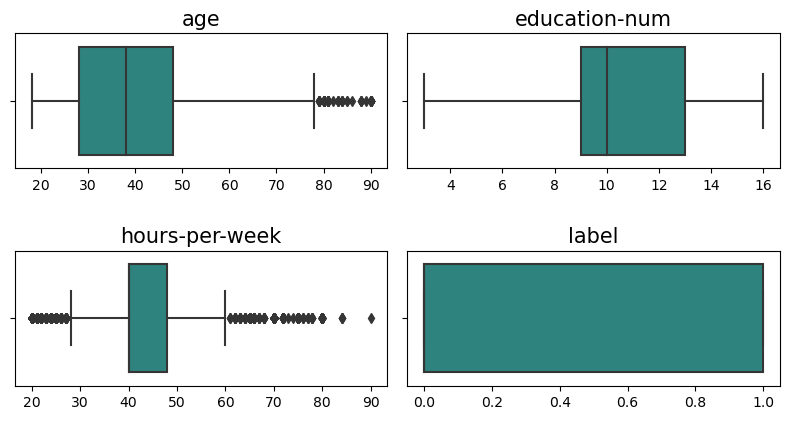

In [15]:
plt.figure(figsize=(8,4.5))
for i in range(0, len(num)):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=eda[num[i]], palette='viridis')
    plt.title(num[i], fontsize=15)
    plt.xlabel(' ')
    plt.tight_layout()

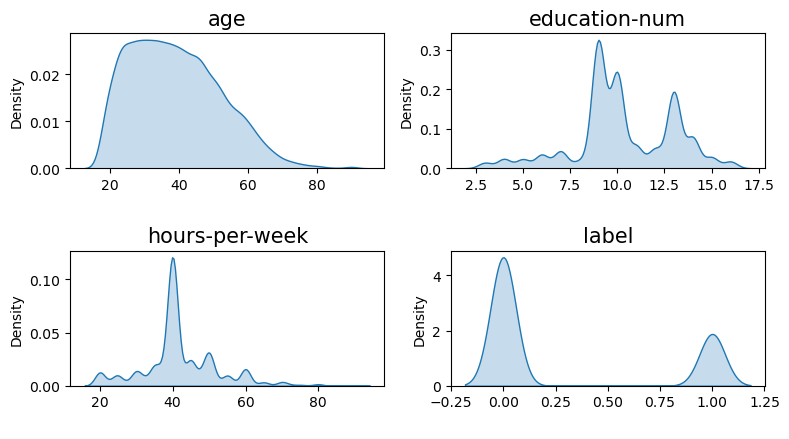

In [16]:
plt.figure(figsize=(8,4.5))
for i in range(0, len(num)):
    plt.subplot(2,2,i+1)
    sns.kdeplot(x=eda[num[i]], palette='viridis', shade=True)
    plt.title(num[i], fontsize=15)
    plt.xlabel(' ')
    plt.tight_layout()

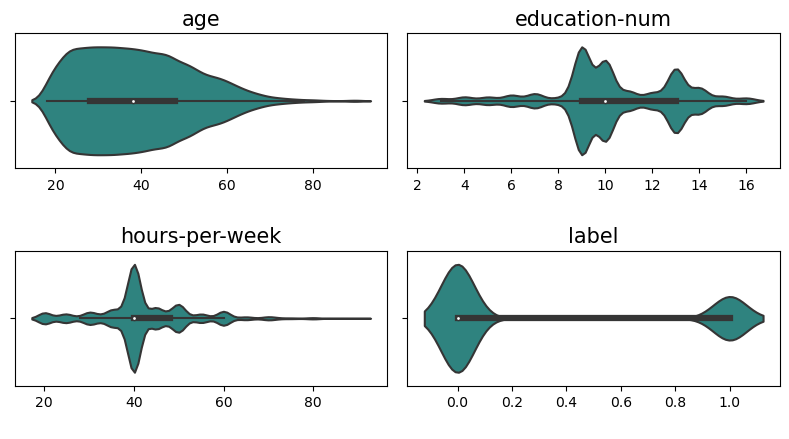

In [17]:
plt.figure(figsize=(8,4.5))
for i in range(0, len(num)):
    plt.subplot(2,2,i+1)
    sns.violinplot(x=eda[num[i]], palette='viridis')
    plt.title(num[i], fontsize=15)
    plt.xlabel(' ')
    plt.tight_layout()

### Categoric Features

In [18]:
len(cat)

6

In [19]:
eda[cat].nunique()

sex                2
education         14
marital-status     6
workclass          5
occupation        12
income             2
dtype: int64

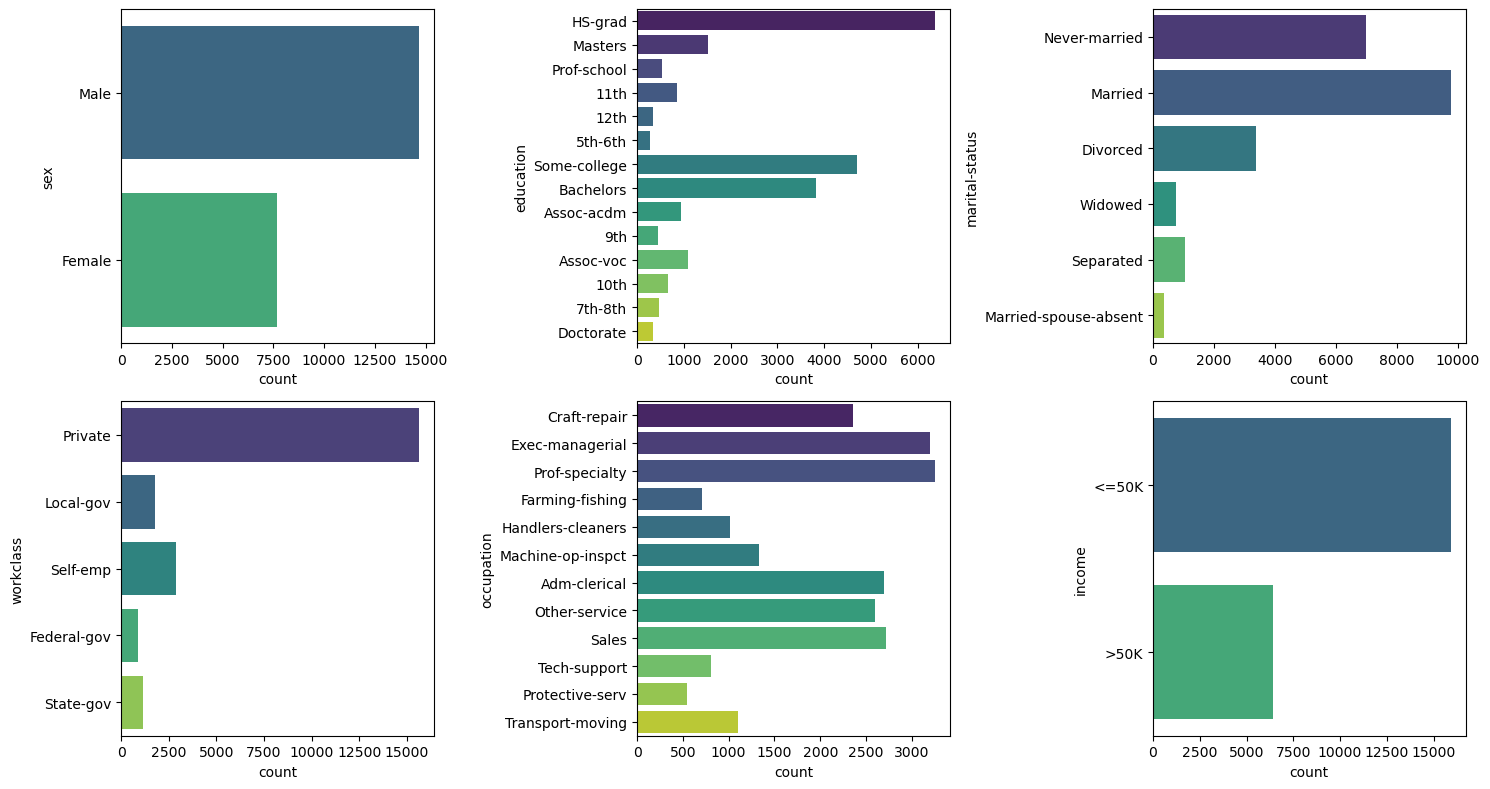

In [21]:
fig, axes = plt.subplots(2,3, figsize=(15,8))
xy = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]

for i in range(len(cat)):
    sns.countplot(y=eda[cat[i]], palette='viridis', ax=axes[xy[i]])
    plt.tight_layout() 

## Bivariate Feature Analysis

### Numeric

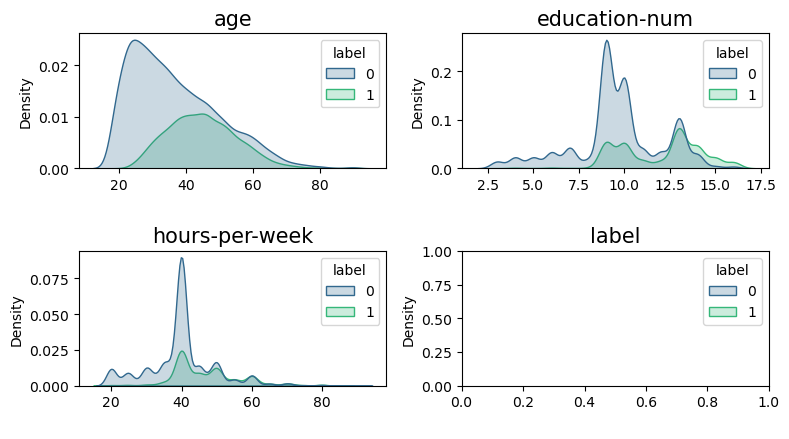

In [23]:
plt.figure(figsize=(8,4.5))
for i in range(0, len(num)):
    plt.subplot(2,2,i+1)
    sns.kdeplot(x=eda[num[i]], palette='viridis', shade=True, hue=eda['label'])
    plt.title(num[i], fontsize=15)
    plt.xlabel(' ')
    plt.tight_layout()

### Category

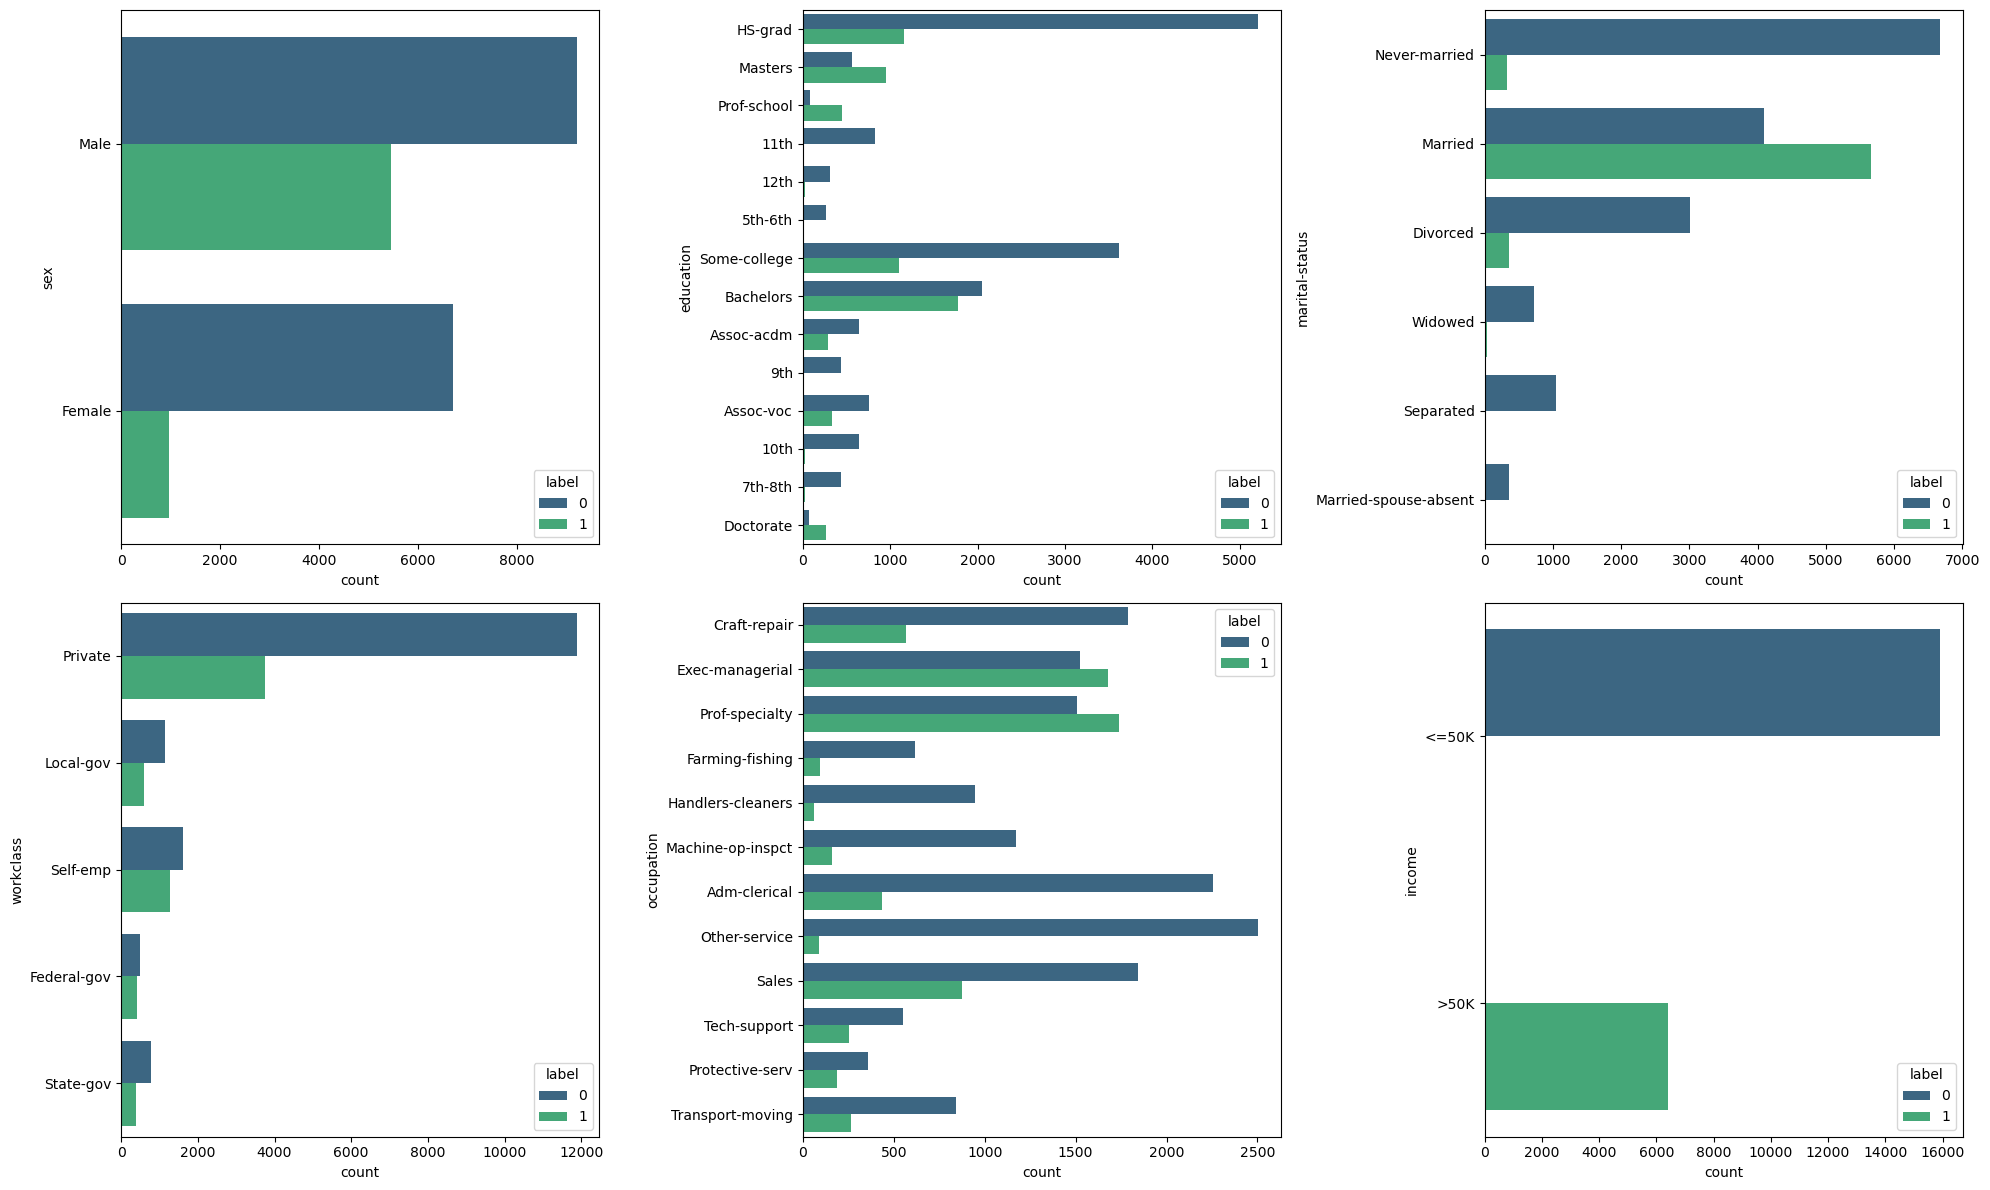

In [25]:
fig, axes = plt.subplots(2,3, figsize=(20,12))
xy = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]

for i in range(len(cat)):
    sns.countplot(y=eda[cat[i]], palette='viridis', ax=axes[xy[i]], hue=eda['label'])
    plt.tight_layout() 

### Correlation Heatmap

<AxesSubplot:>

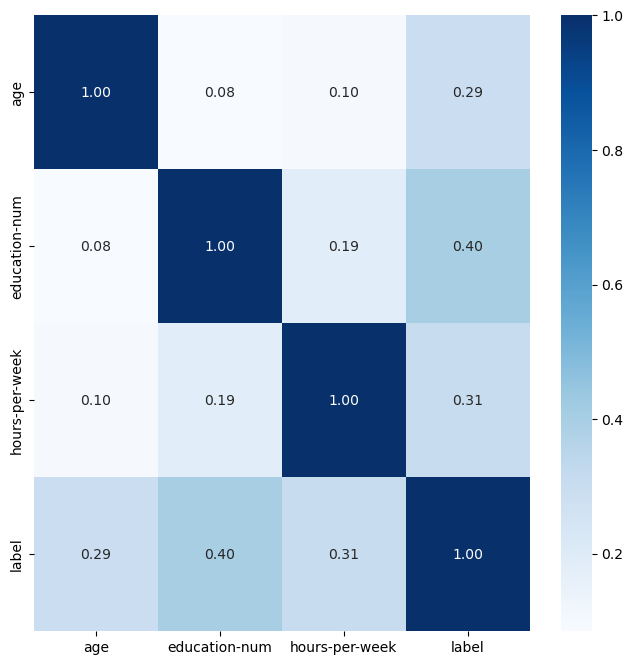

In [27]:
# Create Heatmap Correlation Chart for Each Numerical Features
plt.figure(figsize=(8, 8))
sns.heatmap(eda.corr(), cmap='Blues', annot=True, fmt='.2f')

### Pairplot

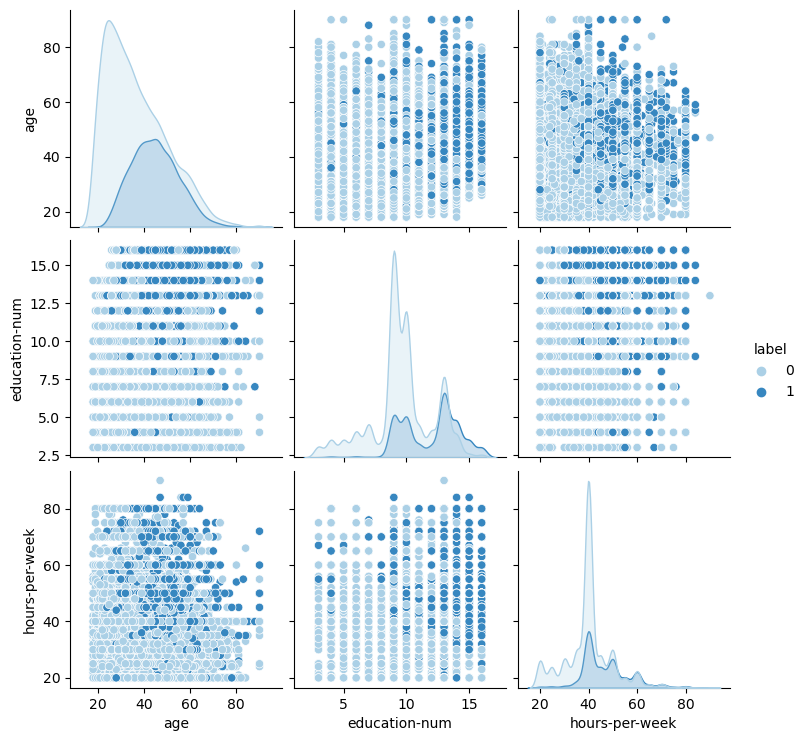

In [28]:
sns.pairplot(eda, hue='label', palette='Blues')

# Data Preprocessing

## Define Category and Numeric Features

In [29]:
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

print(f'cat_cols  has {len(cat_cols)} columns')  # 5
print(f'cont_cols has {len(cont_cols)} columns') # 2
print(f'y_col     has {len(y_col)} column')      # 1

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


## Convert categorical columns to category dtypes

In [30]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [31]:
df.dtypes

age                  int64
sex               category
education         category
education-num        int64
marital-status    category
workclass         category
occupation        category
hours-per-week       int64
income              object
label                int64
dtype: object

## Embedding Sizes

In [32]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

## Create an Array of Categorical Values

In [33]:
sx = df['sex'].cat.codes.values
ed = df['education'].cat.codes.values
ms = df['marital-status'].cat.codes.values
wc = df['workclass'].cat.codes.values
oc = df['occupation'].cat.codes.values

cats = np.stack([sx,ed,ms,wc,oc], 1)

cats[:5]

array([[ 1, 10,  3,  2,  1],
       [ 1, 11,  1,  1,  2],
       [ 1, 10,  0,  3,  7],
       [ 0, 12,  3,  0,  7],
       [ 0,  1,  5,  2,  3]], dtype=int8)

In [34]:
# Convert "cats" to a tensor
cats = torch.tensor(cats, dtype=torch.int64)

In [36]:
type(cats)

torch.Tensor

## Create an Array of Numeric Values

In [38]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts[:5]

array([[27, 40],
       [47, 50],
       [59, 20],
       [38, 57],
       [64, 40]])

In [39]:
# Convert "conts" to a tensor
conts = torch.tensor(conts, dtype=torch.float)
conts.dtype

torch.float32

## Convert Label to Tensor

In [40]:
y = torch.tensor(df[y_col].values).flatten()
y

tensor([0, 1, 0,  ..., 1, 1, 1])

## Train Test Split

In [41]:
df.shape

(22325, 10)

In [42]:
b = 22325 
t = 5000  

cat_train = cats[:b-t]
cat_test  = cats[b-t:b]
con_train = conts[:b-t]
con_test  = conts[b-t:b]
y_train   = y[:b-t]
y_test    = y[b-t:b]

# Modeling

## Build Model

In [43]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [44]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 2, [50], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

## Loss and Optimization Functions

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Model Training

In [47]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.45937979
epoch:  26  loss: 0.42957979
epoch:  51  loss: 0.41127336
epoch:  76  loss: 0.39645290
epoch: 101  loss: 0.37997857
epoch: 126  loss: 0.37153453
epoch: 151  loss: 0.36465678
epoch: 176  loss: 0.35567504
epoch: 201  loss: 0.35064548
epoch: 226  loss: 0.34813651
epoch: 251  loss: 0.34548360
epoch: 276  loss: 0.33845037
epoch: 300  loss: 0.33567879

Duration: 14 seconds


## Loss Function Plot

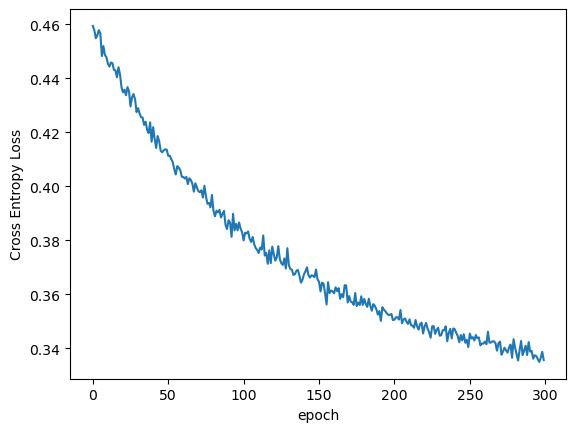

In [49]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

## Model Evaluation

In [50]:
# TO EVALUATE THE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.37036088


In [51]:
# calculating Accuracy

rows = len(y_test)
correct = 0

for i in range(rows):
    # print(f'{str(y_val[i]):26} {y_val[i].argmax().item():^7}{y_test[i]:^7}')

    if y_val[i].argmax().item() == y_test[i]:
        correct += 1

print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


4076 out of 5000 = 81.52% correct
